In [45]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from scipy import stats
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xlsxwriter
pd.options.mode.chained_assignment = None  # default='warn'
import statsmodels.api as sm
from statsmodels.formula.api import ols
## https://www.kaggle.com/code/alexmaszanski/two-way-anova-with-python/notebook
from scipy.stats import linregress
import glob
import researchpy as rp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
from statsmodels.stats.anova import AnovaRM
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


**There are four assumptions that must be met before using two-way ANOVA:**

- Normality: Observations from the sample population are normally distributed.
- Sample Size: The number of observations must be the same for each group.
- Equal Variances: The variances for each group are equal.
- Independence: Observations in each group are independent.

In [83]:
currdir= os.getcwd()
parent = os.path.dirname(currdir)
gparent=os.path.dirname(parent)
lines_to_skip = 10 # adjust this as necessary

# count the number of header lines
header_lines = 3 # adjust this as necessary

plate_type = 'DIV19'
# read the csv file into a pandas DataFrame, skipping the metadata at the top
# df = pd.read_csv(filename, skiprows=lines_to_skip, header=[i for i in range(header_lines)])
### read all data

PERTURBATION = "CNO"
firstTableHeading = "Number of Spikes"
## conditions taken: ### we will define this as dose1,dose2, dose3, dose4, each incrementing in terms of doses
basal_folder = f"{parent}/data/DIV19_CNO/Div19_basal_CNO"
dose1_folder = f"{parent}/data/DIV19_CNO/Div19_5uM_CNO"
dose2_folder = f"{parent}/data/DIV19_CNO/Div19_10uM_CNO"
dose3_folder =f"{parent}/data/DIV19_CNO/Div19_15uM_CNO"
dose4_folder = f"{parent}/data/DIV19_CNO/Div19_20uM_CNO"
doses= {"basal": "basal",
        "dose1": "5uM_CNO",
        "dose2": "10uM_CNO",
        "dose3": "15uM_CNO",
        "dose4": "20uM_CNO"}
# basal_df= pd.read_csv(f"data/Div19_2way/Div19 H11 5th batch of gRNAs plate2 basal(000)(000)_CompiledData(1).csv",
#                     skiprows = lines_to_skip)

# bicucilin_df = pd.read_csv(f"data/Div19_2way/Div19 H11 5th batch of gRNAs plate2 bicu 6 microM(000)(000)_CompiledData.csv",
#                          skiprows = lines_to_skip)

# basal_df = basal_df.drop(columns=['Unnamed: 9']) # , 'Unnamed: 0'
# bicucilin_df = bicucilin_df.drop(columns=['Unnamed: 9']) # , 'Unnamed: 0'
# basal_df

In [3]:
def read_csvs_to_dict(folder):
    files = glob.glob(os.path.join(folder, "*.csv"))
    data_dict = {}
    for file in files:
        # Extracting the plate number from the filename
        plate_num = re.search(r'plate\s?(\d+)', file, re.IGNORECASE)
        if plate_num:
            plate_key = f"plate_{plate_num.group(1)}"
            df = pd.read_csv(file, skiprows = lines_to_skip)
            df = df.drop(columns=['Unnamed: 9'])
            data_dict[plate_key] = df
    return data_dict
basal_files_dict = read_csvs_to_dict(basal_folder)
dose1_files_dict = read_csvs_to_dict(dose1_folder)
dose2_files_dict = read_csvs_to_dict(dose2_folder)
dose3_files_dict = read_csvs_to_dict(dose3_folder)
dose4_files_dict = read_csvs_to_dict(dose4_folder)

for ind, dictionary in enumerate([basal_files_dict, dose1_files_dict, dose2_files_dict, dose3_files_dict, dose4_files_dict]):
    print(list(doses.keys())[ind], dictionary.keys() )

basal dict_keys(['plate_3', 'plate_1'])
dose1 dict_keys(['plate_3', 'plate_1'])
dose2 dict_keys(['plate_3', 'plate_1'])
dose3 dict_keys(['plate_1', 'plate_3'])
dose4 dict_keys(['plate_3', 'plate_1'])


In [4]:
def concat_plates(dfs_dict, firstHeading):
    experiment = {}
    testparams_concat = {}
    for plate, df in dfs_dict.items():
        maxrows = df.shape[0]
        vals_between_tables = 16
        titles = [heading_ind for heading_ind in range(14, maxrows+16, 16)]
        titles.insert(0,0)
        # # Empty dictionary to store dataframes
        # Loop through start indices
        for ind in range(len(titles) -1):
            if ind == 0:
                ## Handle mean firing rate
                key = firstHeading
                table = df.iloc[titles[ind] : titles[ind +1], :]
                # table = rename_row_names(table)
            elif ind != 0:
                table = df.iloc[titles[ind] : titles[ind +1], :]
                key = table.iloc[0][0] # just get name
                table = df.iloc[titles[ind] +2: titles[ind +1], :]

            table.set_index('Unnamed: 0', inplace=True)
            if key not in experiment:
                experiment[key] = []
            experiment[key].append(table)
    
    for testparam, df_list in experiment.items():
        concated_table = pd.concat(df_list, ignore_index=False)
        testparams_concat[testparam] = concated_table
    
    testparams_concat = {key.strip(): value for key, value in testparams_concat.items()}
    return testparams_concat

basal_dict_wmeanSEM= concat_plates(basal_files_dict, firstTableHeading)
dose1_dict_wmeanSEM = concat_plates(dose1_files_dict, firstTableHeading)
dose2_dict_wmeanSEM = concat_plates(dose2_files_dict, firstTableHeading)
dose3_dict_wmeanSEM = concat_plates(dose3_files_dict, firstTableHeading)
dose4_dict_wmeanSEM = concat_plates(dose4_files_dict, firstTableHeading)

dose4_dict_wmeanSEM.keys()

dict_keys(['Number of Spikes', 'Mean Firing Rate (Hz)', 'ISI Coefficient of Variation - Avg', 'Network ISI Coefficient of Variation', 'Fano Factor', 'Number of Active Electrodes', 'Weighted Mean Firing Rate (Hz)', 'Number of Bursts', 'Number of Bursting Electrodes', 'Burst Duration - Avg (sec)', 'Burst Duration - Std (sec)', 'Burst Duration (Median) - Avg (sec)', 'Burst Duration (Median) - Std (sec)', 'Number of Spikes per Burst - Avg', 'Number of Spikes per Burst - Std', 'Number of Spikes per Burst (Median) - Avg', 'Number of Spikes per Burst (Median) - Std', 'Mean ISI within Burst - Avg (sec)', 'Mean ISI within Burst - Std (sec)', 'Median ISI within Burst - Avg (sec)', 'Median ISI within Burst - Std (sec)', 'Median/Mean ISI within Burst - Avg', 'Median/Mean ISI within Burst - Std', 'Inter-Burst Interval - Avg (sec)', 'Inter-Burst Interval - Std (sec)', 'Inter-Burst Interval (Median) - Avg (sec)', 'Inter-Burst Interval (Median) - Std (sec)', 'Burst Frequency - Avg (Hz)', 'Burst Freque

In [5]:
def remove_mean_SEM(dictionary, chemical_type):
    for key, value in dictionary.items():
        to_drop = [index for index in ['B Mean', 'B SEM'] if index in value.index]
        if to_drop:
            dictionary[key] = value.drop(index=to_drop)
        dictionary[key]['Chemical_Type']=chemical_type
    return dictionary

basal_dictmessy = remove_mean_SEM(basal_dict_wmeanSEM, chemical_type="basal")
dose1_dictmessy = remove_mean_SEM(dose1_dict_wmeanSEM,chemical_type="CNO_5uM")
dose2_dictmessy = remove_mean_SEM(dose2_dict_wmeanSEM, chemical_type="CNO_10uM")
dose3_dictmessy = remove_mean_SEM(dose3_dict_wmeanSEM, chemical_type="CNO_15uM")
dose4_dictmessy = remove_mean_SEM(dose4_dict_wmeanSEM, chemical_type="CNO_20uM")

# print(basal_dict['Number of Covered Electrodes'].columns)
# dose1_dictmessy['Mean Firing Rate (Hz)']
dose1_dictmessy.keys()


dict_keys(['Number of Spikes', 'Mean Firing Rate (Hz)', 'ISI Coefficient of Variation - Avg', 'Network ISI Coefficient of Variation', 'Fano Factor', 'Number of Active Electrodes', 'Weighted Mean Firing Rate (Hz)', 'Number of Bursts', 'Number of Bursting Electrodes', 'Burst Duration - Avg (sec)', 'Burst Duration - Std (sec)', 'Burst Duration (Median) - Avg (sec)', 'Burst Duration (Median) - Std (sec)', 'Number of Spikes per Burst - Avg', 'Number of Spikes per Burst - Std', 'Number of Spikes per Burst (Median) - Avg', 'Number of Spikes per Burst (Median) - Std', 'Mean ISI within Burst - Avg (sec)', 'Mean ISI within Burst - Std (sec)', 'Median ISI within Burst - Avg (sec)', 'Median ISI within Burst - Std (sec)', 'Median/Mean ISI within Burst - Avg', 'Median/Mean ISI within Burst - Std', 'Inter-Burst Interval - Avg (sec)', 'Inter-Burst Interval - Std (sec)', 'Inter-Burst Interval (Median) - Avg (sec)', 'Inter-Burst Interval (Median) - Std (sec)', 'Burst Frequency - Avg (Hz)', 'Burst Freque

In [6]:
def rename_row_names(experiment_df):
    # 'Unnamed: 0' is a column
    experiment_df = experiment_df.reset_index()
    experiment_df = experiment_df.drop(columns="Unnamed: 0", errors="ignore")
    experiment_df.index = ["Replicate{}".format(i+1) for i in range(len(experiment_df))]
    return experiment_df

basal_dict = {key: rename_row_names(df) for key, df in basal_dictmessy.items()}
dose1_dict = {key: rename_row_names(df) for key, df in dose1_dictmessy.items()}
dose2_dict = {key: rename_row_names(df) for key, df in dose2_dictmessy.items()}
dose3_dict = {key: rename_row_names(df) for key, df in dose3_dictmessy.items()}
dose4_dict = {key: rename_row_names(df) for key, df in dose4_dictmessy.items()}

dose4_dict['Area Under Normalized Cross-Correlation']

,GPR37L 1,GPR37L 2,LGI2 A12,SLITRK5,THSD7 1,THSD7 2,unt1,unt2,Chemical_Type
Replicate1,0.811807,0.906937,0.899005,0.169264,0.905866,0.906121,0.475602,0.827052,CNO_20uM
Replicate2,0.843811,0.922759,0.859383,0.803390,0.821709,0.611799,0.883640,0.766874,CNO_20uM
Replicate3,0.789908,0.805033,0.879862,0.766735,0.870340,0.599955,0.807094,0.790625,CNO_20uM
Replicate4,0.790604,0.759227,0.753952,0.791039,0.701266,0.437450,0.924152,0.727266,CNO_20uM
Replicate5,0.756699,0.772317,0.703058,0.912441,0.752198,0.662612,0.877899,0.839144,CNO_20uM
Replicate6,0.819782,0.383124,0.770476,0.860648,0.849338,0.866018,0.885912,0.898878,CNO_20uM
Replicate7,0.773740,0.776289,0.861705,0.791274,0.606826,0.673092,0.736872,0.855151,CNO_20uM
Replicate8,0.869545,0.830755,0.838316,0.813700,0.825099,0.753348,0.905300,0.862859,CNO_20uM
Replicate9,0.867991,0.759383,0.911125,0.858803,0.896841,0.900117,0.815475,0.895443,CNO_20uM
Replicate10,0.803211,0.851787,0.890784,0.903456,0.789252,0.842383,0.851792,0.886679,CNO_20uM


In [22]:
all_dicts = dict(zip(doses.keys(),[basal_dict, dose1_dict, dose2_dict, dose3_dict, dose4_dict]))
all_dicts['basal']['Mean Firing Rate (Hz)']

,GPR37L 1,GPR37L 2,LGI2 A12,SLITRK5,THSD7 1,THSD7 2,unt1,unt2,Chemical_Type
Replicate1,1.998131,2.480482,3.545681,0.635797,4.162791,3.440822,2.032600,3.481935,basal
Replicate2,0.106312,0.941860,1.087002,1.029693,0.445390,0.392234,1.375208,0.515158,basal
Replicate3,0.438953,2.119394,1.528654,1.060631,0.283638,0.159468,2.204527,1.246885,basal
Replicate4,0.313538,0.938331,0.412583,1.411130,0.299834,0.127284,2.550249,0.411337,basal
Replicate5,0.409676,0.872716,1.966362,1.630606,0.873131,0.536752,1.439784,1.621885,basal
Replicate6,0.413621,0.329111,0.524709,0.968023,1.083472,1.512251,1.254776,2.459095,basal
Replicate7,0.848837,0.655731,1.789037,1.564784,1.218439,0.774709,1.980897,0.884551,basal
Replicate8,1.208264,1.370640,1.837209,1.511005,0.846346,0.554194,1.269726,2.671512,basal
Replicate9,1.439369,2.109842,1.538206,2.290490,1.908015,2.876869,1.673588,5.962832,basal
Replicate10,1.073297,1.202243,2.366902,1.546719,4.039244,2.847799,2.359635,2.512043,basal


In [47]:
def combine_chem_types(dict_of_alldicts):
    all_concat = {key: None for key in dict_of_alldicts['basal']}
    for type in dict_of_alldicts.keys():
        for test_parameter, df in dict_of_alldicts[type].items():
            all_concat[test_parameter]=pd.concat([all_concat[test_parameter], df], ignore_index=False)
    for testparam, df in all_concat.items():
        df.columns = df.columns.str.replace(' ', '_')
        for gene in df.columns:
            if gene != "Chemical_Type":
                df[gene]= df[gene].astype(float)
    return all_concat

TestParams_dict = combine_chem_types(all_dicts)
print(TestParams_dict['Network Burst Duration - Avg (sec)']['Chemical_Type'].unique())
TestParams_dict['Network Burst Duration - Avg (sec)']

['basal' 'CNO_5uM' 'CNO_10uM' 'CNO_15uM' 'CNO_20uM']


,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
Replicate1,0.515602,0.275804,0.299611,0.153560,0.313449,0.629291,0.129732,0.442584,basal
Replicate2,0.456160,0.609680,0.411280,0.211851,0.818760,0.611080,0.617689,0.485347,basal
Replicate3,0.475272,0.312015,0.328272,0.306593,0.325360,0.465728,0.346704,1.029175,basal
Replicate4,0.266829,0.289651,0.437453,0.274847,0.236337,0.490340,0.470589,0.588527,basal
Replicate5,0.351653,0.691735,0.388146,0.381597,0.313384,0.294000,0.388658,0.338665,basal
...,...,...,...,...,...,...,...,...,...
Replicate20,0.591627,0.379505,0.804832,0.385078,0.220158,0.255051,0.274449,0.786059,CNO_20uM
Replicate21,0.399590,0.247037,0.656560,0.238772,0.353993,0.328126,0.254977,0.409850,CNO_20uM
Replicate22,0.321443,0.285138,0.436361,0.256321,0.336752,0.271602,0.203636,0.292878,CNO_20uM
Replicate23,0.602579,0.222490,0.255736,0.319258,0.350008,0.203949,0.222146,0.339187,CNO_20uM


In [57]:
TestParams_dict['Synchrony Index']


,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
Replicate1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,basal
Replicate2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,basal
Replicate3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,basal
Replicate4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,basal
Replicate5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,basal
...,...,...,...,...,...,...,...,...,...
Replicate20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNO_20uM
Replicate21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNO_20uM
Replicate22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNO_20uM
Replicate23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNO_20uM


In [64]:
def impute_nans(testparam, table):
    chem_types = table['Chemical_Type']
    table = table.drop(columns=['Chemical_Type'])
    original_index = table.index
    imputer = IterativeImputer(max_iter=100, random_state=0)
    imputed_data = imputer.fit_transform(table)

    # Convert the imputed data back to a DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=table.columns, index=original_index)
    imputed_df['Chemical_Type'] = chem_types
    return imputed_df

TestParams_dict_imputed = {test_param: table for test_param, table in TestParams_dict.items()}
for key, table in TestParams_dict.items():
    if table.loc[:, table.columns != 'Chemical_Type'].isna().all().all():
        del TestParams_dict_imputed[key]
    else:
        TestParams_dict_imputed[key] = impute_nans(key, table)

In [66]:
def melt_df_Long(df):
    new_df = pd.melt(df, id_vars=['Chemical_Type'], var_name='Gene', value_name='Value')
    return new_df

for test_param, table in TestParams_dict_imputed.items():
    TestParams_dict_imputed[test_param] = melt_df_Long(table)

In [71]:
TestParams_dict_imputed['LFP Theta (4-8 Hz) Relative Power - Avg']

,Chemical_Type,Gene,Value
0,basal,GPR37L_1,0.089848
1,basal,GPR37L_1,0.034404
2,basal,GPR37L_1,0.030396
3,basal,GPR37L_1,0.030396
4,basal,GPR37L_1,0.030396
...,...,...,...
955,CNO_20uM,unt2,0.003941
956,CNO_20uM,unt2,0.012384
957,CNO_20uM,unt2,0.002612
958,CNO_20uM,unt2,0.004603


In [76]:
def categorize_gene_vs_control(testparam_df, control_var='unt2'):
    genes = list(testparam_df['Gene'].unique())
    mutants = [gene for gene in genes if "unt" not in gene]
    mutVcont_dict= {mut: pd.DataFrame for mut in mutants}
    for mutant in mutants:
        tiny_df = testparam_df[(testparam_df['Gene'] == control_var) |\
                   (testparam_df['Gene'] == mutant)]
        mutVcont_dict[mutant] = tiny_df
    return mutVcont_dict

TestParamsSectioned_dict = TestParams_dict_imputed.copy()

for test_param, table in TestParams_dict_imputed.items():
    TestParamsSectioned_dict[test_param] = categorize_gene_vs_control(table, control_var='unt2')

TestParamsSectioned_dict['Number of Active Electrodes']

{'GPR37L_1':     Chemical_Type      Gene  Value
 0           basal  GPR37L_1    8.0
 1           basal  GPR37L_1    6.0
 2           basal  GPR37L_1    8.0
 3           basal  GPR37L_1    8.0
 4           basal  GPR37L_1    8.0
 ..            ...       ...    ...
 955      CNO_20uM      unt2    8.0
 956      CNO_20uM      unt2    8.0
 957      CNO_20uM      unt2    8.0
 958      CNO_20uM      unt2    8.0
 959      CNO_20uM      unt2    7.0
 
 [240 rows x 3 columns],
 'GPR37L_2':     Chemical_Type      Gene  Value
 120         basal  GPR37L_2    8.0
 121         basal  GPR37L_2    8.0
 122         basal  GPR37L_2    7.0
 123         basal  GPR37L_2    8.0
 124         basal  GPR37L_2    7.0
 ..            ...       ...    ...
 955      CNO_20uM      unt2    8.0
 956      CNO_20uM      unt2    8.0
 957      CNO_20uM      unt2    8.0
 958      CNO_20uM      unt2    8.0
 959      CNO_20uM      unt2    7.0
 
 [240 rows x 3 columns],
 'LGI2_A12':     Chemical_Type      Gene  Value
 240      

In [77]:
### You want to troubleshoot w PRISM??

TESTPARAM = 'Area Under Normalized Cross-Correlation'
GENEINT = 'GPR37L_1'
# TestParamsSectioned_dict[TESTPARAM][GENEINT].to_csv(f"{parent}/data/PRISM_inputs/{TESTPARAM}_{GENEINT}.csv")

In [78]:
TestParamsSectioned_dict[TESTPARAM][GENEINT]

,Chemical_Type,Gene,Value
0,basal,GPR37L_1,0.876175
1,basal,GPR37L_1,0.708844
2,basal,GPR37L_1,0.684976
3,basal,GPR37L_1,0.711226
4,basal,GPR37L_1,0.675352
...,...,...,...
955,CNO_20uM,unt2,0.671000
956,CNO_20uM,unt2,0.812628
957,CNO_20uM,unt2,0.786426
958,CNO_20uM,unt2,0.804125


In [79]:
def ensure_dirs_exists(path):
    directory = os.path.dirname(path)  # Get the directory part of the file path
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

In [80]:

def calculate_ANOVA(testparameter, df, mutant_gene, anovaRM=True,
                    show_barlabels = False, control_var="unt2"):
    """_summary_
    In a two-way repeated anova measurement test, 1 factor== within-subject, each 
        subject is exposed to all levels of this factor (chemical_Type).
        -Value is dependent variable
        -Gene is index, each gene is eitehr control or mutation so it is key identifier
        -Chemical_type is change within each subject
    
    Args:
        testparameter (_type_): _description_from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

    Returns:
        Anova TABLE: showing mut (1) vs control (1), significance of gene
                        perturbation, gene&chemical
                        
            sum_sq: measure of total variation within data. how much data points differ from the mean
            df (deg of freedom): independ. values, values that are free to vary once we know
                            constraints (sample means)
            F-statistic:  model variance / residual variance. amount of variance due to the variable.
            P-value: is the variance noted (sum_sq, F-statistic) significant?
    """
    ## Flag vals that have been imputed?
    # Impute missing values using IterativeImputer
    if anovaRM:
        # print(df.shape, df.head())
        df = df.groupby(['Gene', 'Chemical_Type']).mean().reset_index()
        anova_table = AnovaRM(df, depvar='Value', subject='Gene', within=['Chemical_Type']).fit()
        print(anova_table)
    else:
        model = ols('Value ~ C(Gene) + C(Chemical_Type) + C(Gene):C(Chemical_Type)', data= df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_table = anova_table.drop('Residual')
        # anova_table = anova_table.rename(index={'C(Gene)': f'C({mutant_gene})'})
    return anova_table

ANOVA_dict = {test_param: {} for test_param, dictionary in TestParamsSectioned_dict.items()}
for test_param, mutVcontrol_dict in TestParamsSectioned_dict.items():
    for mut, table in mutVcontrol_dict.items():
        if table['Chemical_Type'].nunique() > 1:
            ANOVA_dict[test_param][mut]= calculate_ANOVA(test_param, table, mut, anovaRM=False)

# ANOVA_dict['Mean Firing Rate (Hz)']['GPR37L_1']

/home/poojaparameswaran/anaconda3/envs/dataenv/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/poojaparameswaran/anaconda3/envs/dataenv/lib/python3.11/site-packages/statsmodels/base/model.py:1917: RuntimeWarning: invalid value encountered in divide
  F /= J
/home/poojaparameswaran/anaconda3/envs/dataenv/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/poojaparameswaran/anaconda3/envs/dataenv/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 0
  warnings.warn('covariance of constraints doe

In [81]:
ANOVA_dict

{'Number of Spikes': {'GPR37L_1':                                 sum_sq   df         F    PR(>F)
  C(Gene)                   2.481401e+07  1.0  0.245248  0.620914
  C(Chemical_Type)          5.140376e+08  4.0  1.270117  0.282516
  C(Gene):C(Chemical_Type)  2.087835e+08  4.0  0.515876  0.724134,
  'GPR37L_2':                                 sum_sq   df          F    PR(>F)
  C(Gene)                   1.346810e+09  1.0  12.104504  0.000602
  C(Chemical_Type)          8.065801e+08  4.0   1.812292  0.127264
  C(Gene):C(Chemical_Type)  4.114668e+08  4.0   0.924519  0.450376,
  'LGI2_A12':                                 sum_sq   df         F    PR(>F)
  C(Gene)                   2.664449e+08  1.0  2.787158  0.096383
  C(Chemical_Type)          9.913169e+08  4.0  2.592428  0.037399
  C(Gene):C(Chemical_Type)  6.339602e+08  4.0  1.657892  0.160675,
  'SLITRK5':                                 sum_sq   df         F    PR(>F)
  C(Gene)                   2.274330e+08  1.0  3.248194  0.072811
  

In [85]:
def create_multind_df(ANOVA_dict):
    pd.set_option('display.float_format', lambda x: '%.1e' % x)
    test_params = list(ANOVA_dict.keys())
    mutant_genes = list(ANOVA_dict[test_params[0]].keys())
    anova_variables = list(ANOVA_dict[test_params[0]][mutant_genes[0]].index)
    
    col_iterables = [mutant_genes, ["F-statistic", "P-value"]]
    row_iterables = [test_params, anova_variables]
    
    rindex = pd.MultiIndex.from_product(row_iterables, names=["Test Parameter", "ANOVA variables"])
    cindex = pd.MultiIndex.from_product(col_iterables)
    
    df = pd.DataFrame(index=rindex, columns= cindex)
    for test_param, testparam_dict in ANOVA_dict.items():
        for mutant, anova_df in testparam_dict.items():
            for var in anova_variables:
                df.loc[(test_param, var), (mutant, 'F-statistic')] = anova_df.loc[var, 'F']
                df.loc[(test_param, var), (mutant, 'P-value')] = anova_df.loc[var, 'PR(>F)']
                # df.loc[(test_param, 'C(Gene)'), (mutant, 'F-statistic')] = (anova_df['F']['C(Gene)'])
    return df

nf= create_multind_df(ANOVA_dict)
nf.to_csv(f"{parent}/twoWayANOVA_tables/{plate_type}_{PERTURBATION}_ANOVAresults.csv")

In [ ]:
# Sample DataFrame

# Use the 'border' property in CSS to add lines.
styles = [
    dict(selector="th", props=[("border", "1px solid black")]),
    dict(selector="td", props=[("border", "1px solid gray")]),
    dict(selector="th.col_heading",
         props=[("border-right", "2px solid black"),
                ("border-bottom", "2px solid black")]),
    dict(selector="th.row_heading",
         props=[("border-right", "2px solid black"),
                ("border-bottom", "2px solid black")]),
    # Add more selectors for specific borders as needed
]

html = nf.style.set_table_styles(styles).render()

# Save the HTML to a file
with open('styled.html', 'w') as f:
    f.write(html)


In [649]:
def add_barlabels(ax, bar_width=0.35):
        # Iterate through the patches (bars) in the Axes object
        for bar in ax.patches:
                # The bar's width and location can be accessed through the bar's attributes
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                # Format the label with the desired precision here; round(y, 2) for two decimal places
                label = f"{y:.2f}"
                
                # Place the label above the bar, centered
                ax.text(x, y, label, ha='center', va='bottom', color='pink', fontstyle='italic', fontsize=6,
                        bbox=dict(facecolor='pink', alpha=0.3, edgecolor='none', pad=0))

In [715]:
def add_slope_labels(ax, testparam_df, gene_slope_dict, bar_width=0.35):
    mutants = list(testparam_df['Gene'].unique())
    chemical_types = list(testparam_df['Chemical_Type'].unique())
    
    fig_width, fig_height = ax.figure.get_size_inches()
    numgenes_plot = range(len(mutants))
    eg_width = fig_width/ len(numgenes_plot)
    bar_width = ax.patches[0].get_width()
    space_genes = numgenes_plot + eg_width -1 - bar_width
    print(space_genes)
    
    bars = ax.patches
    y_values = [bar.get_height() for bar in bars]
    top_yval = max(y_values)
    for ind, gene in enumerate(mutants):
        ax.text(space_genes[ind], top_yval + 0.01,
                    f"Slope = {gene_slope_dict[gene]['slope']:.2f}\n"
                    f"P-value = {gene_slope_dict[gene]['p']:.2e}",
                    color='green', fontweight='bold', fontsize=6,
                    ha='center', va='bottom',
                    bbox=dict(facecolor='gray', alpha=0.5, edgecolor='none', pad=1))
    # # Iterate through genes and chemical types
    # for gene in genes:
    #     if gene not in gene_slope_dict:
    #         print(f"No slope data for gene: {gene}")
    #         continue

    #     # Find the bars corresponding to the current gene
    #     gene_bars = [bar for bar in ax.patches if bar.get_height() > 0 and 
    #                  plt.getp(bar, 'label').startswith(gene) and 
    #                  plt.getp(bar, 'label').endswith(chemical_types[0])]  # Assuming the first chemical type is present

    #     if not gene_bars:
    #         print(f"No bars found for gene: {gene}")
    #         continue

    #     # Calculate the center x position of the group of bars for each gene
    #     gene_center_x = np.mean([bar.get_x() + bar.get_width() / 2 for bar in gene_bars])

    #     # Check for finite x positions
    #     if np.isfinite(gene_center_x):
    #         # Add the text label for the slope
    #         ax.text(gene_center_x, y_max + y_shift,
    #                 f"Slope = {gene_slope_dict[gene]['slope']:.2f}\n"
    #                 f"P-value = {gene_slope_dict[gene]['p']:.2e}",
    #                 color='green', fontweight='bold', fontsize=14,
    #                 ha='center', va='bottom',
    #                 bbox=dict(facecolor='gray', alpha=0.5, edgecolor='none', pad=1))
    #         print(f"Label added for gene: {gene}")
    #     else:
    #         print(f"Non-finite x position for gene: {gene}")


In [716]:
import itertools

def compute_slope(testparam_df):
    genes = list(testparam_df['Gene'].unique())
    print(genes)
    gene_data_dict = {gene: [] for gene in genes}
    gene_slope_dict = {gene: float for gene in genes}
    for gene, perturb in itertools.product(testparam_df['Gene'].unique(), testparam_df['Chemical_Type'].unique()):
        mask = testparam_df['Gene'].str.contains(gene) & testparam_df['Chemical_Type'].str.contains(perturb)
        gene_data_dict[gene] = testparam_df[mask]['Value'].tolist()
        slope, intercept, r, p, se = linregress(np.arange(len(gene_data_dict[gene])), gene_data_dict[gene])
        gene_slope_dict[gene] = {"slope":slope, "r":r, "p":p, "se":se}
    return gene_slope_dict

trial = compute_slope(TestParams_dict['Network Burst Duration - Avg (sec)'])

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt1', 'unt2']


['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt1', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.00214061685971686, 'r': -0.26784629844326785, 'p': 0.11425031865500147, 'se': 0.001320529990530133}, 'GPR37L_2': {'slope': -0.001962575160875161, 'r': -0.22034749939882375, 'p': 0.19657655908330238, 'se': 0.0014899476480636565}, 'LGI2_A12': {'slope': -0.004071030630630632, 'r': -0.38709957111261345, 'p': 0.01968043428767835, 'se': 0.001662995226965221}, 'SLITRK5': {'slope': 0.0009926321750321754, 'r': 0.16434050154225693, 'p': 0.33817516443591, 'se': 0.0010217836779850714}, 'THSD7_1': {'slope': -0.00045666808236808276, 'r': -0.0592075035051485, 'p': 0.7315917348063781, 'se': 0.0013204498078108157}, 'THSD7_2': {'slope': 0.0012205866151866157, 'r': 0.153364922403405, 'p': 0.37184978750775655, 'se': 0.0013487597713011349}, 'unt1': {'slope': -0.00045876640926640895, 'r': -0.052133226426835544, 'p': 0.7626783567438038, 'se': 0.0015071156075784705}, 'unt2': {'slope

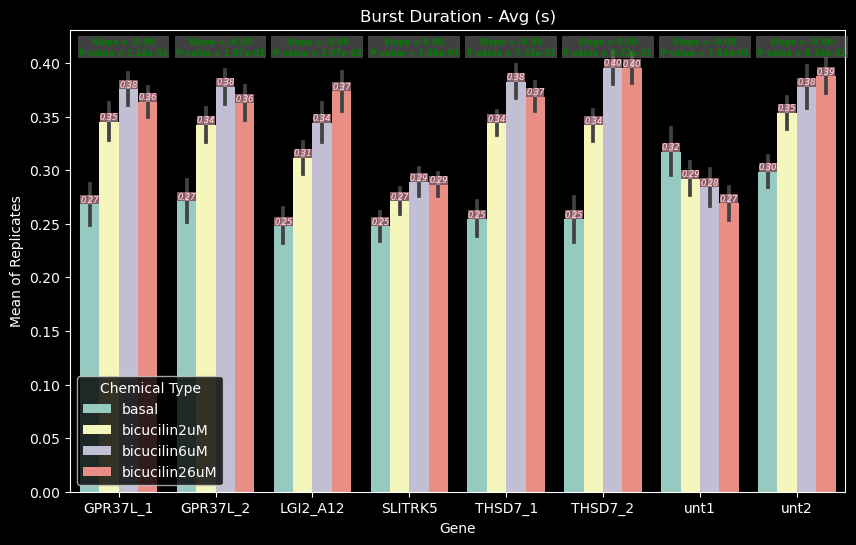

In [717]:
def create_bar_chart(testparameter, df, show_barlabels = True, control_var="unt2"):
    bar_width=0.20
    plt.figure(figsize=(10, 6)) # Adjust the size as needed
    # Create a bar plot
    ax = sns.barplot(x='Gene', y='Value', hue='Chemical_Type', data=df, errorbar='se')

    plt.title(f"{testparameter}")
    plt.xlabel('Gene')
    plt.ylabel('Mean of Replicates')
    plt.legend(title='Chemical Type')
    if show_barlabels:
        add_barlabels(ax)
    gene_slope_dict = compute_slope(df)
    print(f"GENE_SLOPE_dICT: {gene_slope_dict}")
    if show_barlabels:
        add_barlabels(ax)  # This function needs to be defined elsewhere
    add_slope_labels(ax, df, gene_slope_dict, bar_width)  # Adding slope labels to the plot
    # add_slope_labels(genes, chem_mean_dict, axs, gene_slope_dict)
    # plt.tight_layout()
    # save_figfile = f"ANOVA_plots/{plate_type}_ANOVAtest/{testparameter}"
    # ensure_dirs_exists(save_figfile)
    # plt.savefig(save_figfile)
    # plt.show()
    return

for test_param, table in TestParams_dict.items():
    if table['Chemical_Type'].nunique() > 1:
        if test_param == "Burst Duration - Avg (s)":
            create_bar_chart(test_param, table)

In [669]:
def calculate_Tukeys(testparameter, df, show_barlabels = False, control_var="unt2"):  
    ## Perform Tukey's HSD test
    tukey = pairwise_tukeyhsd(endog=df['Value'],
                            groups=df['Gene'] + '_' + df['Chemical_Type'],
                            alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_control = tukey_df[tukey_df['group1'].str.contains('unt2') | tukey_df['group2'].str.contains('unt2')]
    mask = tukey_control['group1'].str.split('_').str[-1] == tukey_control['group2'].str.split('_').str[-1]
    matching_perturb_rows = tukey_control[mask]
    return matching_perturb_rows

In [ ]:
0101010
1
0101010
0
0101010